In [1]:
import os
import random
import shutil
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Define paths
source = 'C:/Users/Kholoud/Desktop/jupyter notebook/SkinMate-Dataset-20240630T095515Z-001/SkinMate-Dataset'
sourceAcnes = os.path.join(source, 'acnes')
sourceBlackheads = os.path.join(source, 'blackheads')
sourceDarkSpots = os.path.join(source, 'darkspots')
sourceWrinkles = os.path.join(source, 'wrinkles')

print(f"There are {len(os.listdir(sourceAcnes))} images of acnes.")
print(f"There are {len(os.listdir(sourceBlackheads))} images of blackheads.")
print(f"There are {len(os.listdir(sourceDarkSpots))} images of darkspots.")
print(f"There are {len(os.listdir(sourceWrinkles))} images of wrinkles.")

There are 250 images of acnes.
There are 250 images of blackheads.
There are 250 images of darkspots.
There are 246 images of wrinkles.


In [4]:
# Define directories
root_dir = 'C:/Users/Kholoud/Desktop/jupyter notebook/SkinMateee'
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

train_dir = os.path.join(root_dir, 'training')
val_dir = os.path.join(root_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [5]:
# Create directories for each class
classes = ['acnes', 'blackheads', 'darkspots', 'wrinkles']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

In [6]:
# Function to split data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    files = [f for f in os.listdir(SOURCE_DIR) if os.path.getsize(os.path.join(SOURCE_DIR, f)) > 0]
    train_size = int(len(files) * SPLIT_SIZE)
    train_set = random.sample(files, train_size)
    val_set = list(set(files) - set(train_set))
    for f in train_set:
        shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join(TRAINING_DIR, f))
    for f in val_set:
        shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join(VALIDATION_DIR, f))

In [7]:
# Split data
split_size = 0.8
for cls in classes:
    split_data(os.path.join(source, cls), os.path.join(train_dir, cls), os.path.join(val_dir, cls), split_size)


In [8]:
# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(150, 150))
        img = img_to_array(img)
        img = img.flatten()
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
# Prepare data
X_train, y_train = [], []
X_val, y_val = [], []
for idx, cls in enumerate(classes):
    X, y = load_images_from_folder(os.path.join(train_dir, cls), idx)
    X_train.append(X)
    y_train.append(y)
    X, y = load_images_from_folder(os.path.join(val_dir, cls), idx)
    X_val.append(X)
    y_val.append(y)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_val = np.vstack(X_val)
y_val = np.hstack(y_val)

In [10]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
# Train SVM model
model = svm.SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [12]:
# Evaluate model
y_pred = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred, target_names=classes))

Validation Accuracy: 0.905
              precision    recall  f1-score   support

       acnes       1.00      1.00      1.00        50
  blackheads       0.91      1.00      0.95        50
   darkspots       0.83      0.86      0.84        50
    wrinkles       0.88      0.76      0.82        50

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.90      0.91      0.90       200



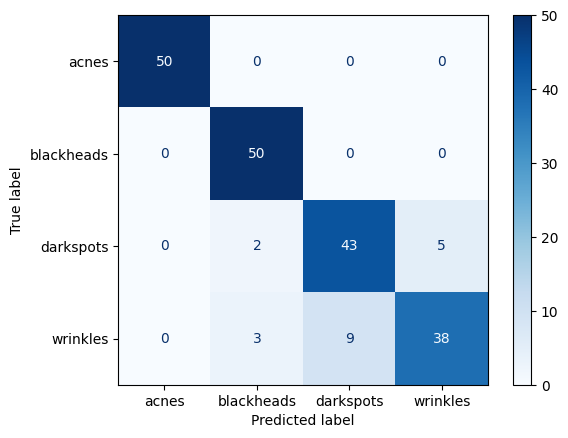

In [13]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, display_labels=classes, cmap=plt.cm.Blues)
plt.show()

In [38]:
# Save the model
import joblib
joblib.dump(model, "svm_skinmate_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [26]:
# Load and predict new image
def predict_image(filepath, model, scaler):
    img = load_img(filepath, target_size=(150, 150))
    img = img_to_array(img)
    img = img.flatten()
    img = scaler.transform([img])
    prediction = model.predict(img)
    return classes[prediction[0]]

In [31]:
# Example usage
print(predict_image("C:/Users/Kholoud/Downloads/WhatsApp Image 2024-07-08 at 3.23.15 PM (2).jpeg", model, scaler))

blackheads


In [32]:
# Load and predict new image with probabilities
def predict_image_with_probabilities(filepath, model, scaler):
    img = load_img(filepath, target_size=(150, 150))
    img = img_to_array(img)
    img = img.flatten()
    img = scaler.transform([img])
    probabilities = model.predict_proba(img)[0]  # Get the probabilities for each class
    return probabilities

In [33]:
# Example usage
probabilities = predict_image_with_probabilities("C:/Users/Kholoud/Downloads/WhatsApp Image 2024-07-08 at 3.23.15 PM (2).jpeg", model, scaler)


In [34]:
# Print the probabilities for each class
for cls, prob in zip(classes, probabilities):
    print(f"{cls}: {prob * 100:.2f}%")

acnes: 1.75%
blackheads: 28.45%
darkspots: 22.45%
wrinkles: 47.36%


In [37]:
import h5py
import pickle

# Save the model to an HDF5 file
with h5py.File('svc_modelllll.h5', 'w') as f:
    # Save the model parameters
    model_params = pickle.dumps(model)
    f.create_dataset('model_params', data=np.void(model_params))

print("Model saved to svc_model.h5")

Model saved to svc_model.h5
